Segment customers of an e-commerce site using DBSCAN
=================

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [2]:
# import the following libraries

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

#### DBSCAN Clustering

DBSCAN groups ‘densely grouped’ data points into a single cluster. It can identify clusters in large spatial datasets by looking at the local density of the data points. 

* The most exciting feature of DBSCAN clustering is that it is robust to outliers. 

* It also does not require the number of clusters to be told beforehand, unlike K-Means.

DBSCAN requires only two parameters: epsilon and minPoints. 

* Epsilon is the radius of the circle to be created around each data point to check the density 
* minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.

In [3]:
# Read the datasets
customer = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
order = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
item = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payment = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')

In [4]:
# Merge the 'customer' and 'order' datasets on the 'customer_id' column
# Keeps only rows with matching 'customer_id' in both datasets (inner join)
df = customer.merge(order, how='inner', on='customer_id')

# Merge the resulting DataFrame with the 'item' dataset on the 'order_id' column
# Keeps only rows with matching 'order_id' in both datasets (inner join)
df = df.merge(item, how='inner', on='order_id')

# Merge the resulting DataFrame with the 'payment' dataset on the 'order_id' column
# Keeps only rows with matching 'order_id' in both datasets (inner join)
df = df.merge(payment, how='inner', on='order_id')

# lets see first 5 columns
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25


In [5]:
# check for duplicated data
df.duplicated().sum()

0

In [6]:
#Only consider the order_status which are delivered
df= df.loc[df.order_status=='delivered']

In [7]:
date_columns = ['order_purchase_timestamp','order_approved_at', 
                'order_delivered_carrier_date','order_delivered_customer_date', 
                'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
payment_sequential                        int64
payment_type                             object
payment_installments                    

In [8]:
# Create a new dataset
df = df[['customer_unique_id', 'order_id', 'payment_type', 'order_delivered_carrier_date', 
         'order_purchase_timestamp' ,'order_approved_at', 'payment_value']]

df.isna().sum().sort_values(ascending=False)

order_approved_at               15
order_delivered_carrier_date     2
customer_unique_id               0
order_id                         0
payment_type                     0
order_purchase_timestamp         0
payment_value                    0
dtype: int64

In [9]:
# Drop the NaN values
df=df.dropna()

In [10]:
from datetime import date,timedelta,datetime

# Create the RFM dataset with categorical data
last_date = df['order_delivered_carrier_date'].max() + timedelta(days=1)
RFM = df.groupby(['customer_unique_id']).agg({
    'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
    'order_id': lambda x: len(x),
    'payment_value': 'sum'
})

# Reset the index
RFM.columns=['Recency', 'Frequency', 'MonetaryValue']

# Reset the index
RFM = RFM.reset_index(drop=True)
RFM.head()

,Recency,Frequency,MonetaryValue
0,123,1,141.90
1,126,1,27.19
2,548,1,86.22
3,333,1,43.62
4,299,1,196.89


In [11]:
RFM.shape

(93342, 3)

In [12]:
# Get rid of the outliers

# Remove the outlies from the monetary value
q1_mv = RFM['MonetaryValue'].quantile(0.25)
q3_mv = RFM['MonetaryValue'].quantile(0.75)
IQR = q3_mv - q1_mv
RFM = RFM[(RFM['MonetaryValue'] > q1_mv - 1.5*IQR) & (RFM['MonetaryValue'] < q3_mv + 1.5*IQR)]

In [13]:
std = StandardScaler()
rfm_std = std.fit_transform(RFM)

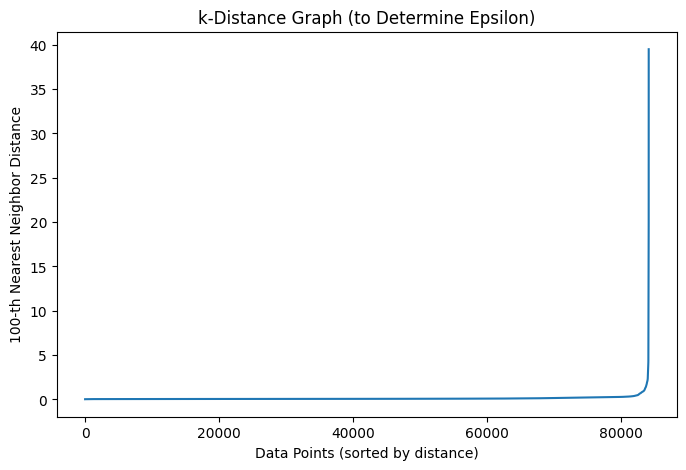

In [14]:
from sklearn.neighbors import NearestNeighbors

k=100
nearest_neighbors = NearestNeighbors(n_neighbors=100)
nearest_neighbors.fit(rfm_std)
distances, indices = nearest_neighbors.kneighbors(rfm_std)

# Step 2: Sort the distances for the k-th neighbor
# k-th distance corresponds to distances[:, k-1]
k_distances = np.sort(distances[:, k - 1])

# Step 3: Plot the k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("k-Distance Graph (to Determine Epsilon)")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.show()

In [15]:
# eps=0.7, min_sample=100
dbscan=DBSCAN(eps=0.7, min_samples=100)

In [16]:
dbs=dbscan.fit(rfm_std)

In [17]:
RFM['dbcluster'] = dbs.labels_

In [18]:
RFM['dbcluster'].value_counts()

dbcluster
 0    75192
 1     7748
-1      886
 2      372
Name: count, dtype: int64

In [19]:
RFM.head()

,Recency,Frequency,MonetaryValue,dbcluster
0,123,1,141.90,0
1,126,1,27.19,0
2,548,1,86.22,0
3,333,1,43.62,0
4,299,1,196.89,0


In [20]:
RFM.dbcluster.value_counts()

dbcluster
 0    75192
 1     7748
-1      886
 2      372
Name: count, dtype: int64

In [21]:
# find the silhoettte score 
dbscan_score = silhouette_score(rfm_std, dbs.labels_, metric='euclidean')
round(dbscan_score, 4)

0.405

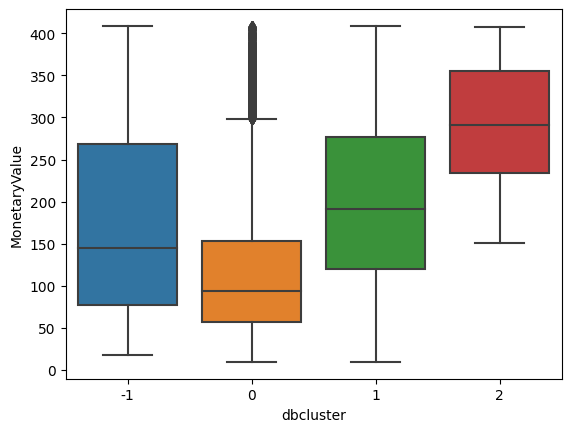

In [22]:
# Plot the boxplot 
sns.boxplot(x='dbcluster', y='MonetaryValue', data=RFM);

Now, the customers are divided into 4 groups, the last cluster are the customers  who spent more.

#### TSNE for DBSCAN

In [23]:
tsne=TSNE(n_components=2, init='pca', perplexity= 35, random_state=42, learning_rate='auto')

In [24]:
tsne=tsne.fit_transform(rfm_std)

In [25]:
tsne_df=pd.DataFrame(data=tsne, columns=['tsne1','tsne2'])

In [26]:
tsne_df=pd.concat([tsne_df, RFM['dbcluster']], axis=1)
tsne_df.head()

,tsne1,tsne2,dbcluster
0,22.237017,-60.469372,0.0
1,-106.417435,-64.568130,0.0
2,12.434538,119.608833,0.0
3,-79.084747,59.777531,0.0
4,45.152973,27.992529,0.0


<ipython-input-27-43ae4988234c>:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x='tsne1', y='tsne2', hue='dbcluster', palette=['red', 'green', 'blue','orange','purple'],


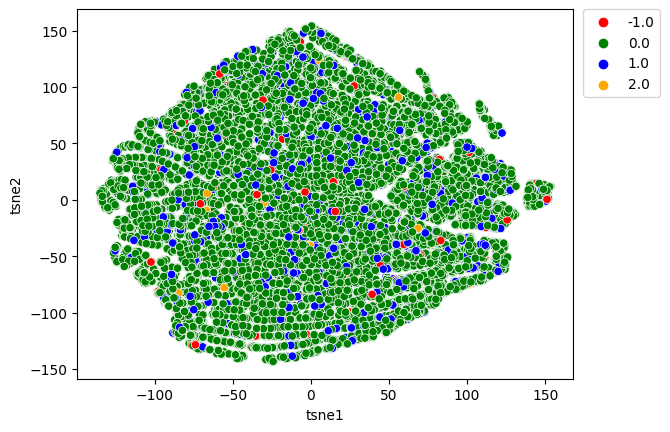

In [27]:
sns.scatterplot(x='tsne1', y='tsne2', hue='dbcluster', palette=['red', 'green', 'blue','orange','purple'], 
                data=tsne_df);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()